In [1]:
using Revise
using HydroSolver
using LinearAlgebra
using StaticArrays
using Statistics
using GLMakie,Makie
using IterativeSolvers
using Unitful
using ProfileView
using JLD2

Gtk-Message: 06:14:12.471: Failed to load module "canberra-gtk-module"


On spécifie le type spatial du mesh: des points 2D.

In [2]:
Point = SVector{2,Float64}

SVector{2, Float64} (alias for SArray{Tuple{2}, Float64, 1, 2})

In [3]:
L_x = inrefunit(2u"mm")
L_y = inrefunit(2u"mm")

L_slot = inrefunit(0.5u"mm")
L_coflow = inrefunit(0.5u"mm")

U_slot = inrefunit(1u"m/s")
T_slot = inrefunit(300u"K")
U_coflow = inrefunit(0.2u"m/s")
T_coflow = inrefunit(300u"K")

ν = inrefunit(15e-6u"m^2/s")
ρ = inrefunit(1.1614u"kg/m^3");

In [4]:
@load "mesh100"
@load "U"
N_x=100
N_y=100
x_range=range(0,stop=L_x,length=N_x)
y_range=range(0,stop=L_y,length=N_y)

N_faces = length(mymesh.faces)
N_cells = length(mymesh.cells);
plot_faces,plot_vertices =  HydroSolver.mesh_to_polygons(mymesh);

In [7]:
species = ["CH4","O2","N2","H2O","CO2"]
BC_Y = Dict{String,Vector{HydroSolver.BoundaryConditions{Float64}}}(
    i=>Vector{HydroSolver.BoundaryConditions{Float64}}(undef,length(mymesh.fCenters))
for i in species)

left_border = [-1 in v && mymesh.fCenters[i][1] < mean(x_range[1:2]) for (i,v) in enumerate(mymesh.faces)]
right_border = [-1 in v && mymesh.fCenters[i][1] > mean(x_range[end-1:end]) for (i,v) in enumerate(mymesh.faces)]
bottom_border = [-1 in v && mymesh.fCenters[i][2] < mean(y_range[1:2]) for (i,v) in enumerate(mymesh.faces)]
top_border = [-1 in v && mymesh.fCenters[i][2] > mean(y_range[end-1:end]) for (i,v) in enumerate(mymesh.faces)]

bottom_slot = [0 <= i[1] <= L_slot for i in mymesh.fCenters] .* bottom_border
top_slot = [0 <= i[1] <= L_slot for i in mymesh.fCenters] .* top_border
bottom_coflow = [L_slot < i[1] <= L_slot+L_coflow for i in mymesh.fCenters] .* bottom_border
top_coflow = [L_slot < i[1] <= L_slot+L_coflow for i in mymesh.fCenters] .* top_border


for i in 1:N_faces
    for s in species
        BC_Y[s][i] = HydroSolver.None{Float64}() 
    end
    if bottom_slot[i]
        BC_Y["O2"][i] = HydroSolver.Dirichlet{Float64}(0.2)
        BC_Y["N2"][i] = HydroSolver.Dirichlet{Float64}(0.8)
        BC_Y["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
    end
    if top_slot[i]
        BC_Y["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["N2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["CH4"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_Y["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
    end
    if bottom_coflow[i]
        BC_Y["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["N2"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_Y["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
    end
    if top_coflow[i]
        BC_Y["O2"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["N2"][i] = HydroSolver.Dirichlet{Float64}(1)
        BC_Y["CH4"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["H2O"][i] = HydroSolver.Dirichlet{Float64}(0)
        BC_Y["CO2"][i] = HydroSolver.Dirichlet{Float64}(0)
    end
end

In [25]:
DiffusY = Dict(i=> HydroSolver.diffusion(mymesh,BC_quantity=BC_Y[i]) for i in species);
∇ = HydroSolver.gradient(mymesh)
J = HydroSolver.interpolation(mymesh,method=:Central)
Sum=HydroSolver.face_sum(mymesh);
fV = HydroSolver.face_vecs(mymesh);

In [101]:
Y = Dict(i=>zeros(N_cells) for i in species)
Y["N2"] = 0.8*ones(N_cells)
Y["O2"] = 0.2*ones(N_cells);

In [136]:
function dt_concentrations(Y)
    Dict(s=> ν*DiffusY[s]*Y[s] - Diagonal(U)*(∇*Y[s]) for s in species)
end
function operator_Y()
    u = HydroSolver.split(Diagonal(U))
    grad = HydroSolver.split(∇)
    Dict(s=> ν*DiffusY[s] - sum(u[i]*grad[i] for i in 1:2) for s in species)
end
opY = operator_Y();

In [144]:
Y = Dict(s=>
    opY[s].A \ (-opY[s].B)
for s in species)

Dict{String, Vector{Float64}} with 5 entries:
  "N2"  => [0.799613, 0.800393, 0.799068, 0.800582, 0.798999, 0.800599, 0.79899…
  "CH4" => [0.000645643, -0.000658092, 0.0015575, -0.000980218, 0.00167641, -0.…
  "H2O" => [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0…
  "CO2" => [-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0  …  -0.0…
  "O2"  => [0.199741, 0.200265, 0.199375, 0.200398, 0.199325, 0.200418, 0.19931…

In [125]:
for i in 1:20000
    dY = dt_concentrations(Y)
    for s in species
        Y[s] += 1e-7 * dY[s]
    end
end

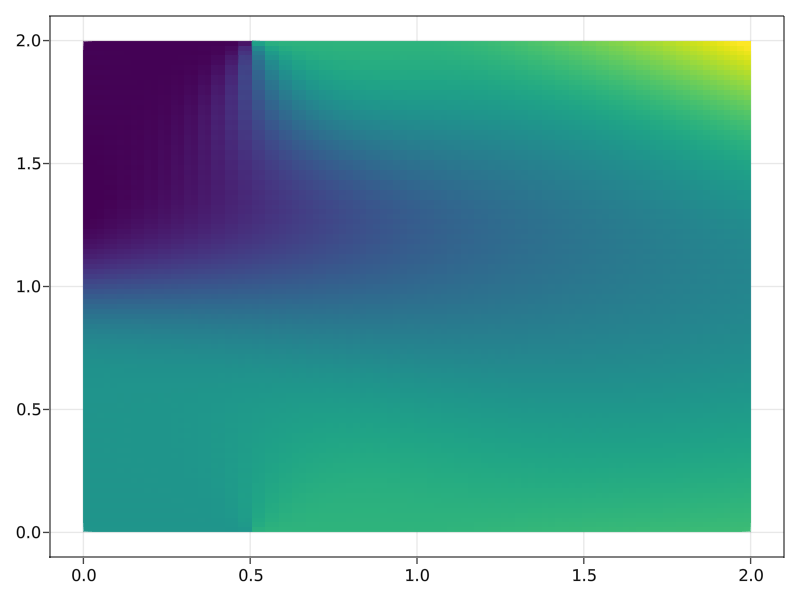

In [157]:
Makie.mesh(plot_vertices,plot_faces, color=HydroSolver.col(Y["N2"]),shading=false)

In [350]:
obs = Observable(HydroSolver.col(P))
fig, ax, data = Makie.mesh(plot_vertices,plot_faces, color=obs,shading=false)
splot= streamplot!(ax,sobs,0..2,0..2, color=:white)
Colorbar(fig[1, 2], data)
ax.title = string("Pressure and velocity for iteration",1)
record(fig, "pressure.mp4", framerate = 60) do io
    global U
    global P
    global splot
    for j in 1001:2000
        U,P=fractional_step(mesh, U, [BC_U_x,BC_U_y], BC_P; dt=5e-6,r=-1e-2, method=:Upwind)
        if j%10==0
            g(x,y) = Point2{Float64}(HydroSolver.continuous_interpolation(mesh,U,Point([x,y])))
            delete!(ax,splot)
            obs[] = HydroSolver.col(P)
            splot=streamplot!(ax,g,0..2,0..2, colormap=:linear_grey_0_100_c0_n256)
            ax.title = string("Pressure and velocity for iteration ",j)
            notify(obs)
            recordframe!(io)
        end
    end
end

"pressure.mp4"

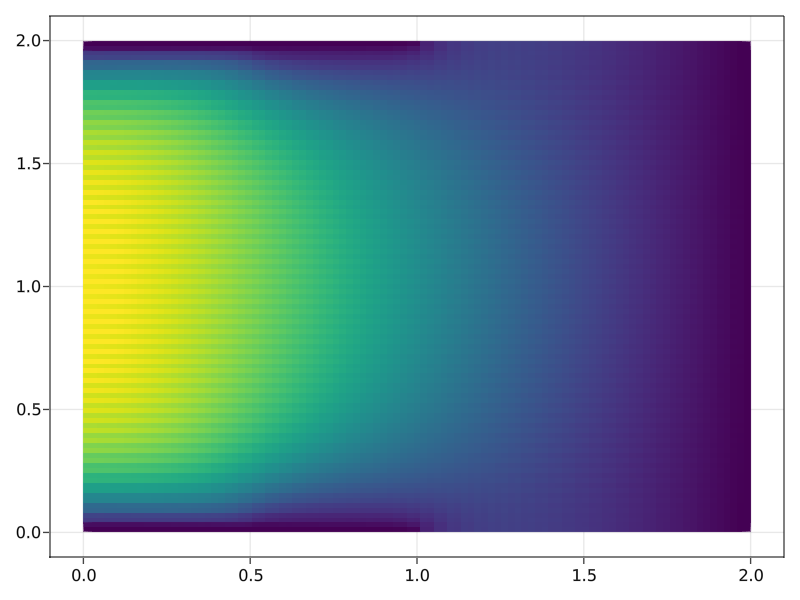

In [351]:
Makie.mesh(plot_vertices,plot_faces, color=HydroSolver.col(P),shading=false)

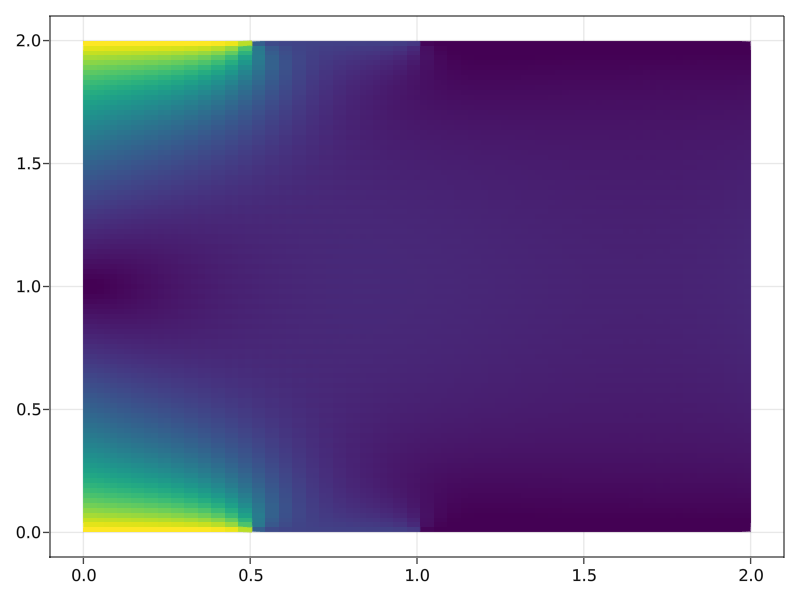

In [352]:
Makie.mesh(plot_vertices,plot_faces, color=HydroSolver.col(norm.(U)),shading=false)

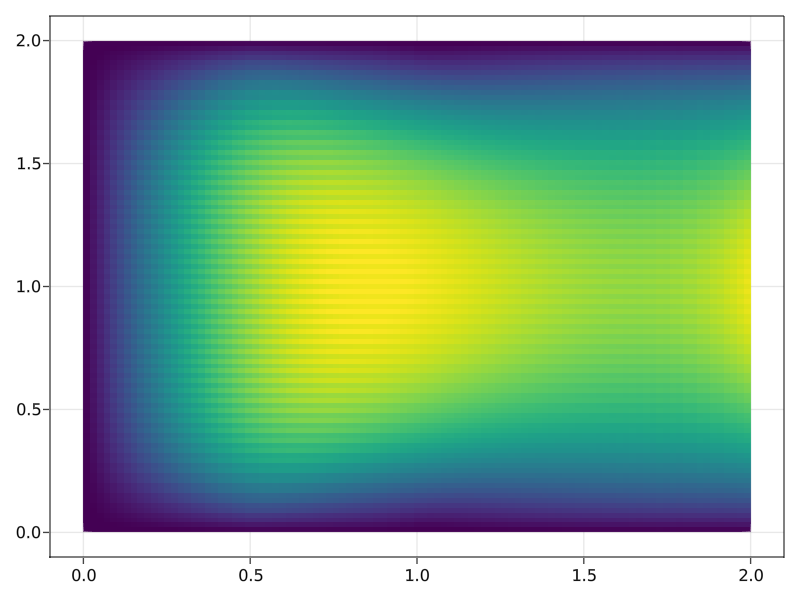

In [353]:
Makie.mesh(plot_vertices,plot_faces, color=HydroSolver.col([i[1] for i in U]),shading=false)

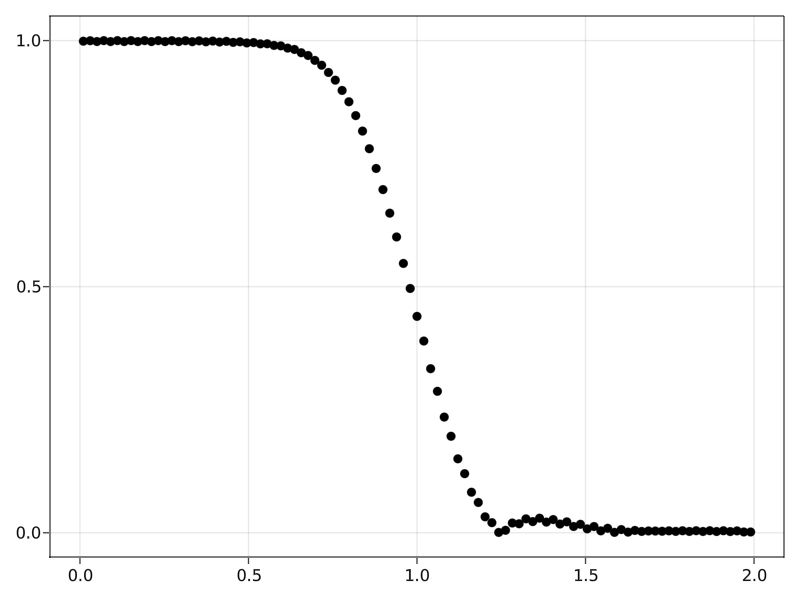

In [174]:
y = HydroSolver.split(mymesh.fCenters)[2][left_border]
n2diffus = abs.((J*Y["N2"])[left_border])
n2diffus/=maximum(n2diffus)
y_diff = y[0.1 .< n2diffus .< 0.9]
maximum(y_diff)-minimum(y_diff)
plot(y,n2diffus)

2606.933033720703

In [505]:
function SIMPLE_iter(mesh, U, BC_U, BC_P)
    interp = HydroSolver.interpolation(mesh,U=U; kwargs...)
    Convec_x  = HydroSolver.advection(mesh, U, BC_velocity=[BC_U_x,BC_U_y], BC_quantity=BC_U_x, summation=Sum, interp=interp)
    Convec_y  = HydroSolver.advection(mesh, U, BC_velocity=[BC_U_x,BC_U_y], BC_quantity=BC_U_y, summation=Sum, interp=interp)
    trM_x = Convec_x - ν * DiffusU_ax[1]
    trM_y = Convec_y - ν * DiffusU_ax[2]
    trM = [trM_x,trM_y]
    M_x = trM_x.A
    M_y = trM_y.A
    M = [M_x,M_y]
    A_x = Diagonal(M_x)
    A_y = Diagonal(M_y)
    A = [A_x,A_y]
    iA_x = inv(A_x)
    iA_y = inv(A_y)
    iA = [iA_x,iA_y]
    interp = HydroSolver.interpolate(mesh,U,HydroSolver.Interpolation{:Upwind})
    u = HydroSolver.split(U)
    for axis in 1:2
        H = (A[axis]-M[axis])*u[axis]
        m  = trM[axis].B
        LHS = (DiffusU_ax[axis].A*iA[axis])
        RHS = Vector(D_u*iA*(H-m-d_p))
        GradP[axis] .= LHS\RHS
        nU[axis] .= iA*H - iA*GradP[axis] # M\(GradP[axis]-m) #
    end
    G_P = [Point([ GradP[1][i] , GradP[2][i] ]) for i in 1:length(mesh.cells)]
    newU = [Point([ nU[1][i] , nU[2][i] ]) for i in 1:length(mesh.cells)]
    return G_P
end

SIMPLE_iter (generic function with 1 method)